In [2]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms as T
import torch.nn as nn
import torch
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from torch.amp import autocast, GradScaler
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"

def set_global_seed(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

    try:
        import cv2
        cv2.setRNGSeed(seed)
    except:
        pass

set_global_seed(42)

In [3]:
class CustomDataset(Dataset):
    """ 
    Custom Dataset that loads all pictures into the memory at the start.
    """
    def __init__(self, root):
        self.class_names = sorted(os.listdir(root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        self.paths = sorted(glob(f"{root}/*/*"))

        print("Loading in ram...")
        self.images = []
        self.labels = []

        for i, path in enumerate(self.paths):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_name = os.path.basename(os.path.dirname(path))
            label = self.class_to_idx[label_name]

            self.images.append(img)
            self.labels.append(label)

            if i % 500 == 0:
                print(f"{i}/{len(self.paths)} pictures loaded...")

        print(f"Loading completed. {len(self.images)} pictures loaded.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

root = os.path.join("Lung X-Ray Image", "Lung X-Ray Image")

dataset = CustomDataset(root)
num_classes = len(dataset.class_names)

Loading in ram...
0/3319 pictures loaded...
500/3319 pictures loaded...
1000/3319 pictures loaded...
1500/3319 pictures loaded...
2000/3319 pictures loaded...
2500/3319 pictures loaded...
3000/3319 pictures loaded...
Loading completed. 3319 pictures loaded.


In [4]:
class TransformDataset(Dataset):
    """" 
    This wrapper applies transformations on-the-fly to the existing dataset.
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
class CLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=0.5):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            if isinstance(img, torch.Tensor):
                img_np = img.permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = np.array(img)
            
            clahe = cv2.createCLAHE(
                clipLimit=self.clip_limit,
                tileGridSize=self.tile_grid_size
            )
            
            if len(img_np.shape) == 3:
                img_clahe = np.zeros_like(img_np)
                for i in range(img_np.shape[2]):
                    img_clahe[:, :, i] = clahe.apply(img_np[:, :, i])
            else:
                img_clahe = clahe.apply(img_np)
            
            img = torch.from_numpy(img_clahe).float() / 255.0
            if len(img_clahe.shape) == 3:
                img = img.permute(2, 0, 1)
        
        return img

class GaussianNoise:
    def __init__(self, mean=0.0, std=0.02, p=0.3):
        self.mean = mean
        self.std = std
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            noise = torch.randn_like(img) * self.std + self.mean
            img = img + noise
            img = torch.clamp(img, 0.0, 1.0)
        return img

class RandomGamma:
    def __init__(self, gamma_range=(0.8, 1.2), p=0.5):
        self.gamma_range = gamma_range
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            gamma = random.uniform(*self.gamma_range)
            img = torch.pow(img, gamma)
        return img

In [6]:
# Train
train_transform_normal = T.Compose([
    CLAHE(clip_limit=2.5, tile_grid_size=(8, 8), p=0.6),
    T.ColorJitter(brightness=0.25, contrast=0.25),
    RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
    GaussianNoise(mean=0.0, std=0.02, p=0.3),
    T.Normalize(mean=[0.5], std=[0.5])
])

train_transform_resized = T.Compose([
    CLAHE(clip_limit=2.5, tile_grid_size=(8, 8), p=0.6),
    T.ColorJitter(brightness=0.25, contrast=0.25),
    RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
    GaussianNoise(mean=0.0, std=0.02, p=0.3),
    T.Normalize(mean=[0.5], std=[0.5]),
    T.Resize((224, 224))
])

# Val
val_transform_normal = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5])
])

val_transform_resized = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5]),
    T.Resize((224, 224))
])

# Test
test_transform_normal = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5])
])

test_transform_resized = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5]),
    T.Resize((224, 224))
])

In [7]:
total = len(dataset)
test_size = int(0.15 * total)
val_size = int(0.15 * total)
train_size = total - val_size - test_size

train_base, val_base, test_base = random_split(dataset, [train_size, val_size, test_size])

train_dataset_normal = TransformDataset(train_base,  transform = train_transform_normal)
train_dataset_resized = TransformDataset(train_base,  transform = train_transform_resized)

val_dataset_normal = TransformDataset(val_base,  transform = val_transform_normal)
val_dataset_resized = TransformDataset(val_base,  transform = val_transform_resized)

test_dataset_normal = TransformDataset(test_base,  transform = test_transform_normal)
test_dataset_resized = TransformDataset(test_base,  transform = test_transform_resized)

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes, input_size=299, dropout=0.5):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
        )

        feature_size = input_size // 8
        flattened_size = 128 * feature_size * feature_size

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=299, patch_size=16, in_channels=3, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x

class MLP(nn.Module):
    def __init__(self, embed_dim=256, hidden_dim=512, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, mlp_ratio=2.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), dropout)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=299, patch_size=16, in_channels=3, num_classes=3,
                embed_dim=256, depth=6, num_heads=8, mlp_ratio=2.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        self.head = nn.Linear(embed_dim, num_classes)
        
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
    def forward(self, x):
        B = x.shape[0]
        
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        
        return x

In [10]:
class BaselineMLP(nn.Module):
    def __init__(self, num_classes, input_size=299, dropout=0.3):
        super().__init__()

        flattened_input = 3 * input_size * input_size

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_input, 200),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
class StackingFeatureExtractor(nn.Module):
    def __init__(self, models, num_classes):
        super().__init__()
        self.models = nn.ModuleList(models)
        
        for model in self.models:
            for param in model.parameters():
                param.requires_grad = False
            model.eval()
        
    
        self.num_classes = num_classes

    @torch.no_grad()
    def forward(self, inputs):
        all_logits = []
        
        for model, x in zip(self.models, inputs):
            logits = model(x)
            all_logits.append(logits)
        
        return torch.cat(all_logits, dim=1)

In [12]:
# Loading the models
# Baseline (MLP)
mlp = BaselineMLP(num_classes, input_size=299, dropout=0.3)
mlp.load_state_dict(torch.load("saved_models/mlp.pth"))

# CNN
cnn = CNN(num_classes, input_size=299, dropout=0.5)
cnn.load_state_dict(torch.load("saved_models/cnn.pth"))

# Vison Transformer
vit = VisionTransformer(
    img_size=299,
    patch_size=23,
    in_channels=3,
    num_classes=num_classes,
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_ratio=2.0,
    dropout=0.1
)
vit.load_state_dict(torch.load("saved_models/vit.pth"))


# Pretrained Resnet50
import torchvision.models as models

pretrained_cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = pretrained_cnn.fc.in_features

pretrained_cnn.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, num_classes)
)
pretrained_cnn.load_state_dict(torch.load("saved_models/pretrained_cnn.pth"))


# Pretrained Vision transformer
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT
pretrained_vit = vit_b_16(weights=weights)
in_features = pretrained_vit.heads.head.in_features
pretrained_vit.heads.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

pretrained_vit.load_state_dict(torch.load("saved_models/pretrained_vit.pth"))

<All keys matched successfully>

## Training

In [13]:
def train_one_epoch(model, normal_loader, resized_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    
    for (normal_images, labels), (resized_images, _) in zip(normal_loader, resized_loader):
        normal_images = normal_images.to(device, non_blocking=True)
        resized_images = resized_images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        with autocast(device):
            outputs = model([normal_images, normal_images, normal_images, resized_images, resized_images])
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.detach()

    return (running_loss / len(normal_loader)).item()


def validate(model, normal_loader, resized_loader, criterion, device):
    model.eval()
    total_correct = 0
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for (normal_images, labels), (resized_images, _) in zip(normal_loader, resized_loader):
            normal_images = normal_images.to(device, non_blocking=True)
            resized_images = resized_images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast(device):
                outputs = model([normal_images, normal_images, normal_images, resized_images, resized_images])
                loss = criterion(outputs, labels)

            running_loss += loss.detach()
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum()
            total_samples += labels.size(0)

    avg_loss = (running_loss / len(normal_loader)).item()
    accuracy = (total_correct / total_samples).item()
    
    return avg_loss, accuracy

In [14]:
from torch.utils.data import ConcatDataset, Subset

# Concatenate val and test for "fresh" data
full_meta_normal = ConcatDataset([val_dataset_normal, test_dataset_normal])
full_meta_resized = ConcatDataset([val_dataset_resized, test_dataset_resized])

# Compute indices for splitting
total_size = len(full_meta_normal)
indices = list(range(total_size))
np.random.seed(42)
np.random.shuffle(indices)

train_split = int(0.6 * total_size)
val_split = int(0.8 * total_size)

train_idx = indices[:train_split]
val_idx = indices[train_split:val_split]
test_idx = indices[val_split:]

# Forging the new subsets
meta_train_normal = Subset(full_meta_normal, train_idx)
meta_train_resized = Subset(full_meta_resized, train_idx)

meta_val_normal = Subset(full_meta_normal, val_idx)
meta_val_resized = Subset(full_meta_resized, val_idx)

meta_test_normal = Subset(full_meta_normal, test_idx)
meta_test_resized = Subset(full_meta_resized, test_idx)

# DataLoaders
stack_train_loader_normal = DataLoader(meta_train_normal, batch_size=32, shuffle=True)
stack_train_loader_resized = DataLoader(meta_train_resized, batch_size=32, shuffle=True)

stack_val_loader_normal = DataLoader(meta_val_normal, batch_size=32, shuffle=False)
stack_val_loader_resized = DataLoader(meta_val_resized, batch_size=32, shuffle=False)

stack_test_loader_normal = DataLoader(meta_test_normal, batch_size=32, shuffle=False)
stack_test_loader_resized = DataLoader(meta_test_resized, batch_size=32, shuffle=False)

In [ ]:
def extract_stacking_features(
    feature_extractor,
    normal_loader,
    resized_loader,
    device
):
    X, y = [], []

    feature_extractor.eval()

    with torch.no_grad():
        for (normal_images, labels), (resized_images, _) in zip(normal_loader, resized_loader):

            normal_images = normal_images.to(device, non_blocking=True)
            resized_images = resized_images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            inputs = [
                normal_images,
                normal_images,
                normal_images,
                resized_images,
                resized_images
            ]

            features = feature_extractor(inputs)

            X.append(features.cpu().numpy())
            y.append(labels.cpu().numpy())

    return np.vstack(X), np.hstack(y)

# Extracting features

In [ ]:
if device == 'cuda':
    torch.cuda.empty_cache()

feature_extractor = StackingFeatureExtractor(models=[mlp, cnn, vit, pretrained_cnn, pretrained_vit], num_classes=3).to(device)

X_train, y_train = extract_stacking_features(
    feature_extractor,
    stack_train_loader_normal,
    stack_train_loader_resized,
    device
)

X_val, y_val = extract_stacking_features(
    feature_extractor,
    stack_val_loader_normal,
    stack_val_loader_resized,
    device
)

X_test, y_test = extract_stacking_features(
    feature_extractor,
    stack_test_loader_normal,
    stack_test_loader_resized,
    device
)

y_train = y_train.astype(int)
y_val   = y_val.astype(int)
y_test  = y_test.astype(int)

if device == 'cuda':
    torch.cuda.empty_cache()

# Hyper parameters search

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "min_child_weight": [1, 5, 10],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3],
}

xgb_base = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best CV accuracy:", grid.best_score_)
print("\nBest hyperparameters:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


c:\Users\TUF Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:43:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV accuracy: 0.8473529411764705

Best hyperparameters:
  colsample_bytree: 0.8
  gamma: 0.1
  learning_rate: 0.01
  max_depth: 2
  min_child_weight: 10
  n_estimators: 400
  subsample: 0.9


# Training on best params

In [ ]:
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

final_xgb = XGBClassifier(
    **grid.best_params_,
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(
    X_trainval,
    y_trainval,
    eval_set=[(X_test, y_test)],
    verbose=True
)


test_preds = final_xgb.predict(X_test)
print("Final test accuracy:", accuracy_score(y_test, test_preds))


[0]	validation_0-mlogloss:1.08920
[1]	validation_0-mlogloss:1.07949
[2]	validation_0-mlogloss:1.07056
[3]	validation_0-mlogloss:1.06123


[4]	validation_0-mlogloss:1.05207
[5]	validation_0-mlogloss:1.04353
[6]	validation_0-mlogloss:1.03502
[7]	validation_0-mlogloss:1.02635
[8]	validation_0-mlogloss:1.01807
[9]	validation_0-mlogloss:1.00950
[10]	validation_0-mlogloss:1.00150
[11]	validation_0-mlogloss:0.99333
[12]	validation_0-mlogloss:0.98544
[13]	validation_0-mlogloss:0.97763
[14]	validation_0-mlogloss:0.96981
[15]	validation_0-mlogloss:0.96233
[16]	validation_0-mlogloss:0.95494
[17]	validation_0-mlogloss:0.94772
[18]	validation_0-mlogloss:0.94037
[19]	validation_0-mlogloss:0.93367
[20]	validation_0-mlogloss:0.92667
[21]	validation_0-mlogloss:0.91956
[22]	validation_0-mlogloss:0.91280
[23]	validation_0-mlogloss:0.90603
[24]	validation_0-mlogloss:0.89974
[25]	validation_0-mlogloss:0.89306
[26]	validation_0-mlogloss:0.88662
[27]	validation_0-mlogloss:0.88050
[28]	validation_0-mlogloss:0.87417
[29]	validation_0-mlogloss:0.86792
[30]	validation_0-mlogloss:0.86178
[31]	validation_0-mlogloss:0.85564
[32]	validation_0-mlogloss

# Explanability

<Figure size 1000x800 with 0 Axes>

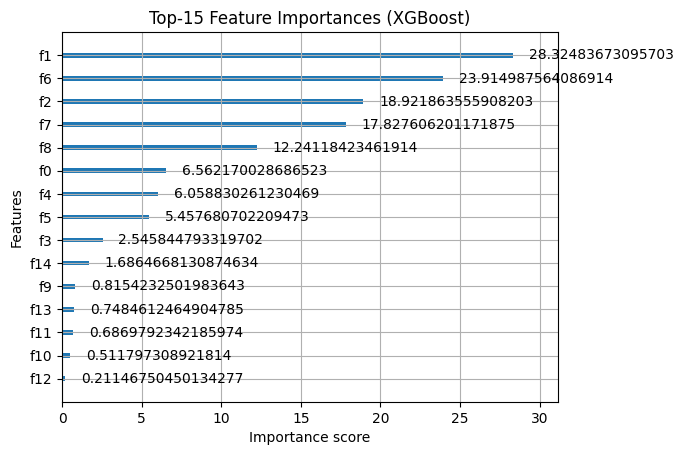

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(
    final_xgb,
    importance_type="gain",
    max_num_features=15
)
plt.title("Top-15 Feature Importances (XGBoost)")
plt.show()


c:\Users\TUF Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\TUF Gaming\AppData\Local\Temp\ipykernel_1016\1912033226.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
c:\Users\TUF Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\TUF Gaming\AppData\Local\Programs\Python\Py

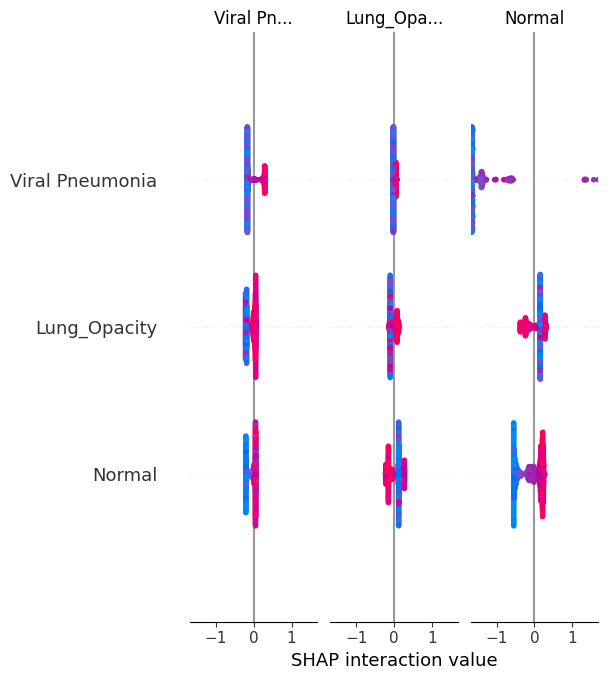

In [ ]:
import shap

explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_trainval)

shap.summary_plot(
    shap_values,
    X_trainval,
    feature_names=dataset.class_names
)

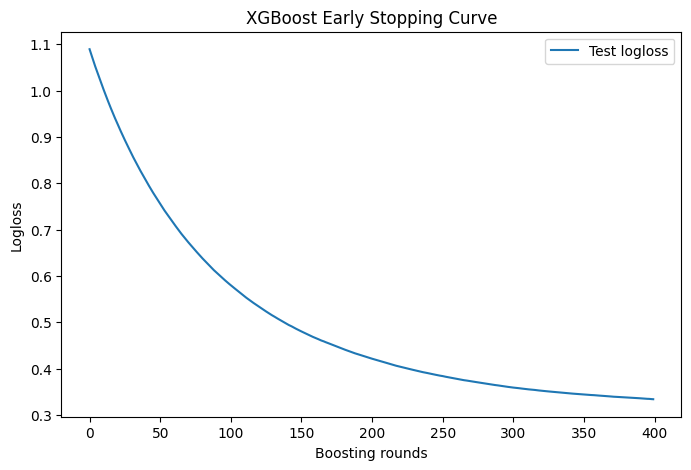

In [ ]:
results = final_xgb.evals_result()

plt.figure(figsize=(8, 5))
plt.plot(results["validation_0"]["mlogloss"], label="Test logloss")
plt.xlabel("Boosting rounds")
plt.ylabel("Logloss")
plt.legend()
plt.title("XGBoost Early Stopping Curve")
plt.show()
